<a href="https://colab.research.google.com/github/esmika-001/Tuberculosis-Detection-in-X-ray-Images/blob/main/UNET_FINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
# Upload your Kaggle API key file
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d nikhilpandey360/chest-xray-masks-and-labels


Dataset URL: https://www.kaggle.com/datasets/nikhilpandey360/chest-xray-masks-and-labels
License(s): CC0-1.0
100% 9.57G/9.58G [05:22<00:00, 32.9MB/s]
100% 9.58G/9.58G [05:22<00:00, 31.9MB/s]


In [ ]:
# Unzip the dataset
import zipfile
with zipfile.ZipFile('chest-xray-masks-and-labels.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/chest_xray_dataset')


In [ ]:
import os

dataset_dir = '/content/chest_xray_dataset'
for root, dirs, files in os.walk(dataset_dir):
    for file in files:
        print(os.path.join(root, file))

/content/chest_xray_dataset/data/Lung Segmentation/NLM-MontgomeryCXRSet-ReadMe.pdf
/content/chest_xray_dataset/data/Lung Segmentation/NLM-ChinaCXRSet-ReadMe.docx
/content/chest_xray_dataset/data/Lung Segmentation/.ipynb_checkpoints/Montgomery-checkpoint.ipynb
/content/chest_xray_dataset/data/Lung Segmentation/ClinicalReadings/CHNCXR_0480_1.txt
/content/chest_xray_dataset/data/Lung Segmentation/ClinicalReadings/CHNCXR_0070_0.txt
/content/chest_xray_dataset/data/Lung Segmentation/ClinicalReadings/CHNCXR_0441_1.txt
/content/chest_xray_dataset/data/Lung Segmentation/ClinicalReadings/CHNCXR_0504_1.txt
/content/chest_xray_dataset/data/Lung Segmentation/ClinicalReadings/CHNCXR_0415_1.txt
/content/chest_xray_dataset/data/Lung Segmentation/ClinicalReadings/CHNCXR_0589_1.txt
/content/chest_xray_dataset/data/Lung Segmentation/ClinicalReadings/CHNCXR_0224_0.txt
/content/chest_xray_dataset/data/Lung Segmentation/ClinicalReadings/CHNCXR_0516_1.txt
/content/chest_xray_dataset/data/Lung Segmentation/C

**LOAD DATA**

In [ ]:
import os
import pandas as pd
from PIL import Image

**CLEAN DATA**

In [ ]:
# # @title Age
# from matplotlib import pyplot as plt
# df['Age'].plot(kind='hist', bins=20, title='Age')
# plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
image_folder = 'chest_xray_dataset/Lung Segmentation/CXR_png/'
results_folder = 'chest_xray_dataset/Lung Segmentation/ClinicalReadings/'
mask_folder = 'chest_xray_dataset/Lung Segmentation/masks/'

data = []

for filename in os.listdir(results_folder):
    if filename.endswith('.txt'):
        with open(os.path.join(results_folder, filename), 'r') as file:
            lines = file.readlines()
            if len(lines) < 2:
                continue
            gender_age = lines[0].strip().split()
            if len(gender_age) != 2:
                continue
            gender = gender_age[0].lower()
            age_with_units = gender_age[1]
            try:
                age = int(age_with_units.replace('yrs', ''))
            except ValueError:
                continue
            diagnosis = lines[1].strip().lower()

        image_base_name = filename.replace('.txt', '')
        image_path_png = os.path.join(image_folder, image_base_name + '.png')
        image_path_jpg = os.path.join(image_folder, image_base_name + '.jpg')

        if os.path.exists(image_path_png):
            image_path = image_path_png
        elif os.path.exists(image_path_jpg):
            image_path = image_path_jpg
        else:
            continue

        mask_path = os.path.join(mask_folder, image_base_name + '_mask.png')
        if not os.path.exists(mask_path):
            continue

        data.append([image_path, mask_path, gender, age, diagnosis])

df_mask = pd.DataFrame(data, columns=['Image', 'Mask', 'Gender', 'Age', 'Diagnosis'])

print(df_mask);

                                                 Image  \
0    chest_xray_dataset/Lung Segmentation/CXR_png/C...   
1    chest_xray_dataset/Lung Segmentation/CXR_png/C...   
2    chest_xray_dataset/Lung Segmentation/CXR_png/C...   
3    chest_xray_dataset/Lung Segmentation/CXR_png/C...   
4    chest_xray_dataset/Lung Segmentation/CXR_png/C...   
..                                                 ...   
543  chest_xray_dataset/Lung Segmentation/CXR_png/C...   
544  chest_xray_dataset/Lung Segmentation/CXR_png/C...   
545  chest_xray_dataset/Lung Segmentation/CXR_png/C...   
546  chest_xray_dataset/Lung Segmentation/CXR_png/C...   
547  chest_xray_dataset/Lung Segmentation/CXR_png/C...   

                                                  Mask  Gender  Age  \
0    chest_xray_dataset/Lung Segmentation/masks/CHN...  female   41   
1    chest_xray_dataset/Lung Segmentation/masks/CHN...  female   20   
2    chest_xray_dataset/Lung Segmentation/masks/CHN...    male   63   
3    chest_xray_dat

In [ ]:
# Check for missing values
print("\nMissing values before dropping:")
print(df_mask.isnull().sum())

df_mask.dropna(inplace=True)

print("\nDataFrame after dropping missing values:")
print(df_mask.head())

df_mask['Gender'] = df_mask['Gender'].replace({'male': 'm', 'female': 'f'})
df_mask = df_mask[df_mask['Diagnosis'].notnull() & (df_mask['Diagnosis'] != '')]

print("\nCleaned DataFrame:")
print(df_mask.head())



Missing values before dropping:
Image        0
Mask         0
Gender       0
Age          0
Diagnosis    0
dtype: int64

DataFrame after dropping missing values:
                                               Image  \
0  chest_xray_dataset/Lung Segmentation/CXR_png/C...   
1  chest_xray_dataset/Lung Segmentation/CXR_png/C...   
2  chest_xray_dataset/Lung Segmentation/CXR_png/C...   
3  chest_xray_dataset/Lung Segmentation/CXR_png/C...   
4  chest_xray_dataset/Lung Segmentation/CXR_png/C...   

                                                Mask  Gender  Age  \
0  chest_xray_dataset/Lung Segmentation/masks/CHN...  female   41   
1  chest_xray_dataset/Lung Segmentation/masks/CHN...  female   20   
2  chest_xray_dataset/Lung Segmentation/masks/CHN...    male   63   
3  chest_xray_dataset/Lung Segmentation/masks/CHN...    male   19   
4  chest_xray_dataset/Lung Segmentation/masks/CHN...    male   23   

                          Diagnosis  
0  ptb in the bilateral upper field  
1        

REFINE and VALIDATE

In [ ]:
print(df_mask.isnull().sum())
df_mask.dropna(inplace=True)  # Option to drop rows with missing values

df_mask['Gender'] = df_mask['Gender'].replace({'male': 'm', 'female': 'f'})

Image        0
Mask         0
Gender       0
Age          0
Diagnosis    0
dtype: int64


<ipython-input-11-a12aabb9b956>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mask.dropna(inplace=True)  # Option to drop rows with missing values
<ipython-input-11-a12aabb9b956>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mask['Gender'] = df_mask['Gender'].replace({'male': 'm', 'female': 'f'})


In [ ]:
df_mask['Age'] = df_mask['Age'].astype(int)

<ipython-input-12-c1be6f9a42b8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mask['Age'] = df_mask['Age'].astype(int)


In [ ]:
df_mask.to_csv('cleaned_lung_xrays_data.csv', index=False)

In [ ]:
df_cleaned = pd.read_csv('cleaned_lung_xrays_data.csv')
print(df_cleaned.head())
print(df_cleaned.info())

                                               Image  \
0  chest_xray_dataset/Lung Segmentation/CXR_png/C...   
1  chest_xray_dataset/Lung Segmentation/CXR_png/C...   
2  chest_xray_dataset/Lung Segmentation/CXR_png/C...   
3  chest_xray_dataset/Lung Segmentation/CXR_png/C...   
4  chest_xray_dataset/Lung Segmentation/CXR_png/C...   

                                                Mask Gender  Age  \
0  chest_xray_dataset/Lung Segmentation/masks/CHN...      f   41   
1  chest_xray_dataset/Lung Segmentation/masks/CHN...      m   63   
2  chest_xray_dataset/Lung Segmentation/masks/CHN...      m   19   
3  chest_xray_dataset/Lung Segmentation/masks/CHN...      m   23   
4  chest_xray_dataset/Lung Segmentation/masks/CHN...      m   54   

                          Diagnosis  
0  ptb in the bilateral upper field  
1      right ptb,right pneumothorax  
2       ptb in the left lower field  
3      ptb in the right upper field  
4           bilateral secondary ptb  
<class 'pandas.core.frame.

EDA

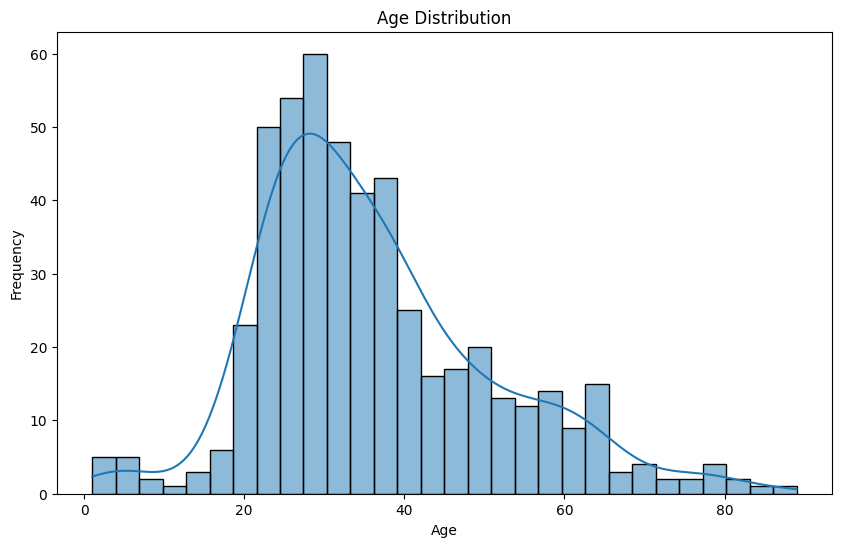

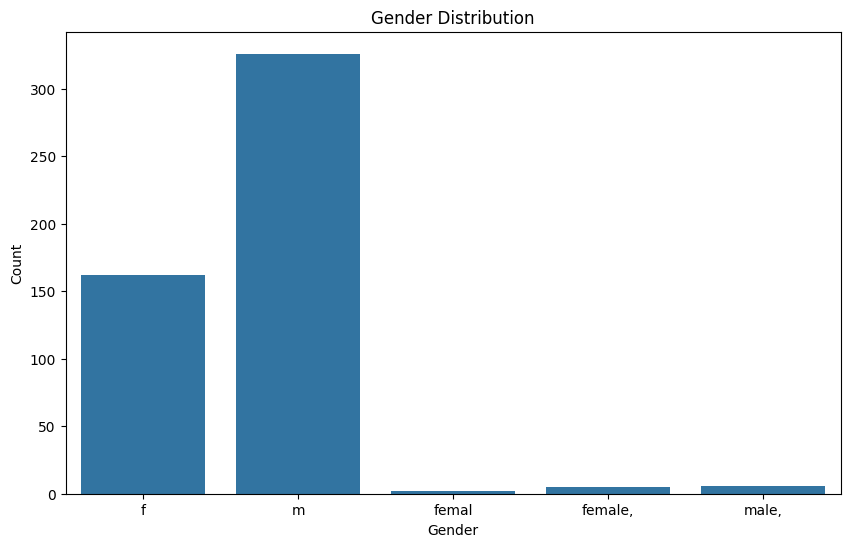

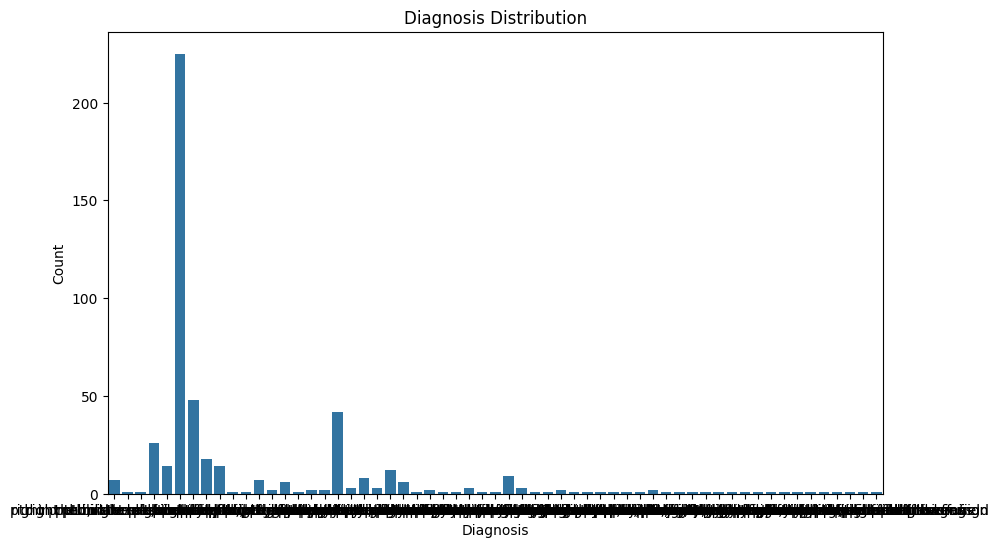

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(df_cleaned['Age'], bins=30, kde=True)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10, 6))
sns.countplot(x='Gender', data=df_cleaned)
plt.title('Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

plt.figure(figsize=(10, 6))
sns.countplot(x='Diagnosis', data=df_cleaned)
plt.title('Diagnosis Distribution')
plt.xlabel('Diagnosis')
plt.ylabel('Count')
plt.show()

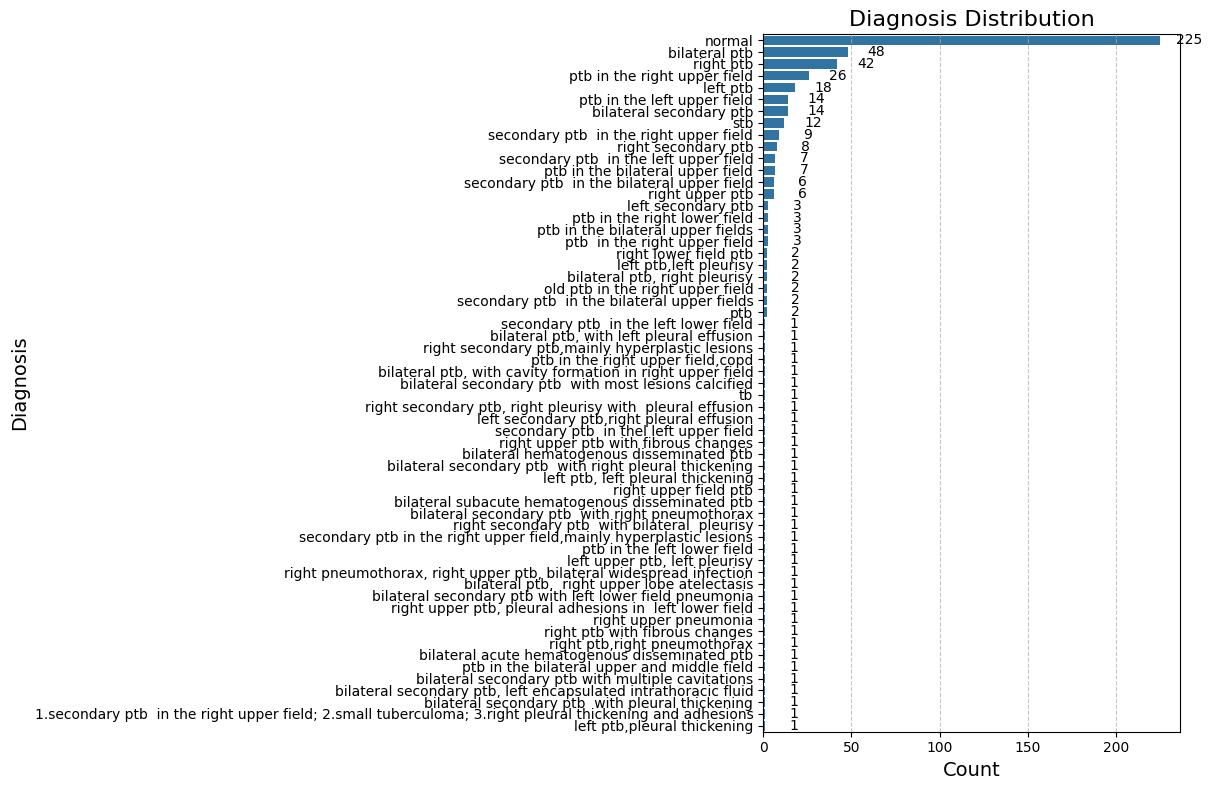

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))
sns.countplot(y='Diagnosis', data=df_cleaned, order=df_cleaned['Diagnosis'].value_counts().index)
plt.title('Diagnosis Distribution', fontsize=16)
plt.xlabel('Count', fontsize=14)
plt.ylabel('Diagnosis', fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.7)

for p in plt.gca().patches:
    plt.gca().annotate(format(p.get_width(), '.0f'),
                       (p.get_width() + 0.5, p.get_y() + p.get_height() / 2.),
                       ha='center', va='center',
                       xytext=(20, 0), textcoords='offset points')

plt.tight_layout()
plt.show()


In [ ]:
df_cleaned['Diagnosis'] = df_cleaned['Diagnosis'].apply(lambda x: 0 if x == 'normal' else 1)
print(df_cleaned['Diagnosis'].value_counts())


Diagnosis
1    276
0    225
Name: count, dtype: int64


Image Preprocessing

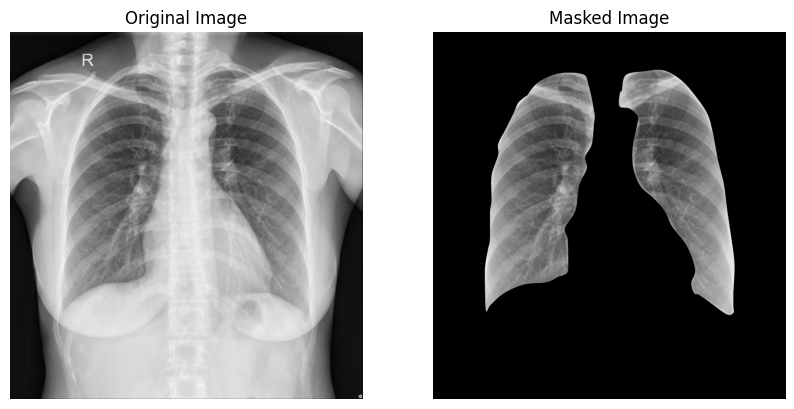

In [ ]:
import cv2

def read_and_preprocess_image(image_path, mask_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    masked_image = cv2.bitwise_and(image, image, mask=mask)

    return masked_image

sample_image_path = df_cleaned['Image'].iloc[0]
sample_mask_path = df_cleaned['Mask'].iloc[0]

sample_image = read_and_preprocess_image(sample_image_path, sample_mask_path)

# Display original and masked image
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(cv2.imread(sample_image_path))
axes[0].set_title('Original Image')
axes[0].axis('off')
axes[1].imshow(sample_image)
axes[1].set_title('Masked Image')
axes[1].axis('off')
plt.show()

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array


df_train, df_val = train_test_split(df_cleaned, test_size=0.2, random_state=42)

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator(rescale=1./255)

# Custom generator
def create_image_generators(df, datagen, batch_size=32, image_size=(256, 256)):
    while True:
        x_batch = []
        y_batch = []
        for _, row in df.iterrows():
            img = load_img(row['Image'], target_size=image_size)
            img = img_to_array(img) / 255.0  # Normalize to [0, 1]
            mask = load_img(row['Mask'], target_size=image_size, color_mode="grayscale")
            mask = img_to_array(mask) / 255.0  # Normalize to [0, 1]
            x_batch.append(img)
            y_batch.append(mask)
            if len(x_batch) == batch_size:
                x_batch = np.array(x_batch, np.float32)
                y_batch = np.array(y_batch, np.float32)
                yield datagen.flow(x_batch, y_batch, batch_size=batch_size, shuffle=True).next()
                x_batch = []
                y_batch = []
        if len(x_batch) > 0:
            x_batch = np.array(x_batch, np.float32)
            y_batch = np.array(y_batch, np.float32)
            yield datagen.flow(x_batch, y_batch, batch_size=len(x_batch), shuffle=True).next()

# Create generators
train_generator = create_image_generators(df_train, train_datagen)
val_generator = create_image_generators(df_val, val_datagen)


UNET

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import pandas as pd

def build_unet_model(input_shape):
    inputs = Input(input_shape)

    # Encoder
    c1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(32, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    # Bottleneck
    c2 = Conv2D(64, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(64, (3, 3), activation='relu', padding='same')(c2)

    # Decoder
    u3 = UpSampling2D((2, 2))(c2)
    u3 = concatenate([u3, c1])
    c3 = Conv2D(32, (3, 3), activation='relu', padding='same')(u3)
    c3 = Conv2D(32, (3, 3), activation='relu', padding='same')(c3)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c3)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

def create_tf_dataset(df, batch_size=4, image_size=(256, 256)):
    def load_and_preprocess(image_path, mask_path):
        image = tf.io.read_file(image_path)
        image = tf.image.decode_png(image, channels=3)
        image = tf.image.resize(image, image_size)
        image = tf.cast(image, tf.float32) / 255.0

        mask = tf.io.read_file(mask_path)
        mask = tf.image.decode_png(mask, channels=1)
        mask = tf.image.resize(mask, image_size)
        mask = tf.cast(mask, tf.float32) / 255.0

        return image, mask

    image_paths = df['Image'].values
    mask_paths = df['Mask'].values

    dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))
    dataset = dataset.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.shuffle(buffer_size=len(df))
    dataset = dataset.batch(batch_size)
    dataset = dataset.repeat()  # Add repeat here
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

# Splitting the dataframe into train and validation sets
df_train, df_val = train_test_split(df_cleaned, test_size=0.2, random_state=42)

# Create the datasets
train_dataset = create_tf_dataset(df_train, batch_size=4)
val_dataset = create_tf_dataset(df_val, batch_size=4)

# Define the model
input_shape = (256, 256, 3)
model = build_unet_model(input_shape)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define callbacks
callbacks = [
    ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss', mode='min'),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001, verbose=1)
]

# Calculate steps_per_epoch and validation_steps
batch_size = 4
steps_per_epoch = len(df_train) // batch_sizeu
validation_steps = len(df_val) // batch_size

# Train the model
history = model.fit(
    train_dataset,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_dataset,
    validation_steps=validation_steps,
    epochs=50,
    callbacks=callbacks
)


Epoch 1/50
100/100 [==============================] - 480s 4s/step - loss: 0.4600 - accuracy: 0.7571 - val_loss: 0.3470 - val_accuracy: 0.8504 - lr: 0.0010
Epoch 2/50
100/100 [==============================] - 445s 4s/step - loss: 0.3102 - accuracy: 0.8698 - val_loss: 0.2881 - val_accuracy: 0.8859 - lr: 0.0010
Epoch 3/50
100/100 [==============================] - 442s 4s/step - loss: 0.2803 - accuracy: 0.8819 - val_loss: 0.2498 - val_accuracy: 0.8959 - lr: 0.0010
Epoch 4/50
100/100 [==============================] - 435s 4s/step - loss: 0.2520 - accuracy: 0.8955 - val_loss: 0.2197 - val_accuracy: 0.9114 - lr: 0.0010
Epoch 5/50
100/100 [==============================] - 440s 4s/step - loss: 0.2310 - accuracy: 0.9063 - val_loss: 0.2278 - val_accuracy: 0.9061 - lr: 0.0010
Epoch 6/50
100/100 [==============================] - 430s 4s/step - loss: 0.2056 - accuracy: 0.9181 - val_loss: 0.2142 - val_accuracy: 0.9082 - lr: 0.0010
Epoch 7/50
100/100 [==============================] - 450s 4s/st

3/3 [==============================] - 49s 16s/step - loss: 50.6551 - accuracy: 0.7490
Validation Loss: 50.6551
Validation Accuracy: 0.7490


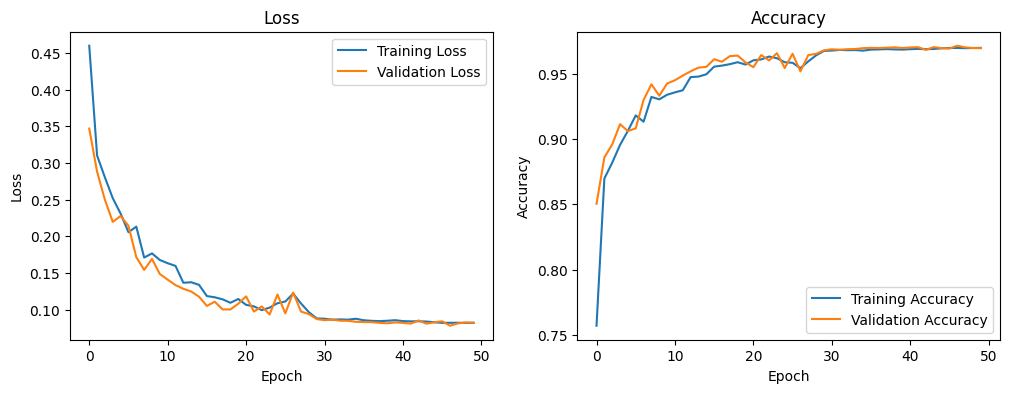

In [ ]:
import os
import matplotlib.pyplot as plt

# Check if the best model file exists
if os.path.exists('best_model.h5'):
    model.load_weights('best_model.h5')
else:
    print("Best model file not found. Ensure the training process saved the best model.")

# Evaluate on validation data
val_steps = len(df_val) // 32

loss, accuracy = model.evaluate(val_generator, steps=val_steps)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")

# Plot training history
plt.figure(figsize=(12, 4))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


4/4 [==============================] - 25s 5s/step
F1 Score: 0.9424
Accuracy: 0.9715
Precision: 0.9497
Recall: 0.9352


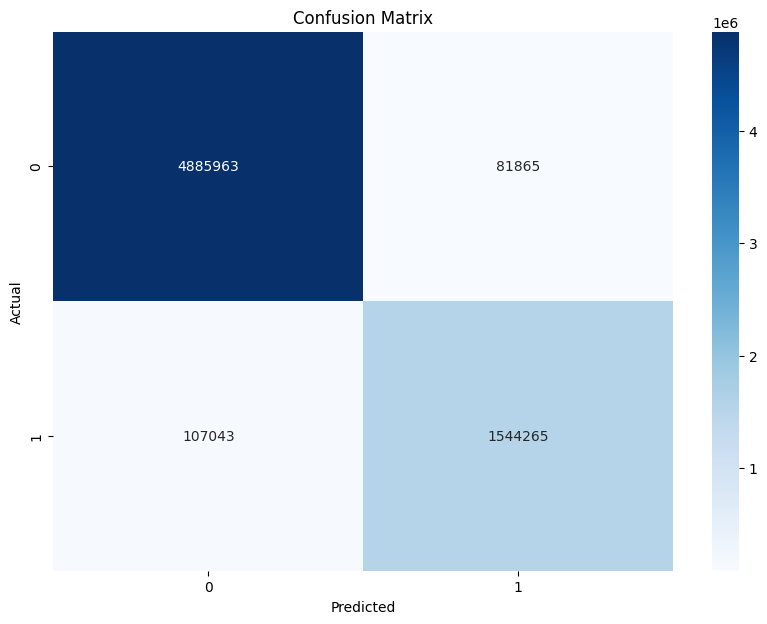

AUC: 0.9593


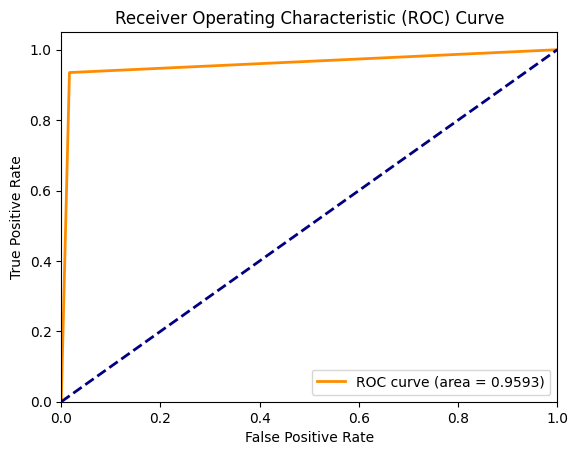

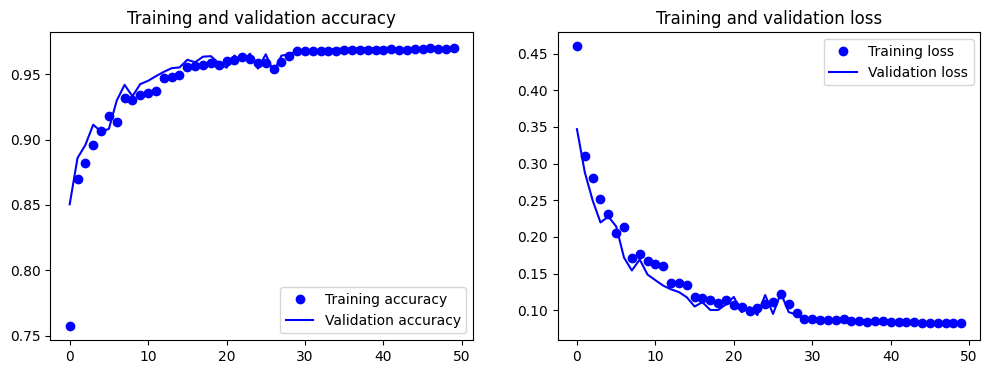

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, f1_score, accuracy_score, precision_score, recall_score
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model('best_model.h5')

# Function to unbatch and collect validation dataset
def get_val_data(val_dataset, dataset_length):
    val_images = []
    val_masks = []
    for images, masks in val_dataset.unbatch().take(dataset_length):
        val_images.append(images.numpy())
        val_masks.append(masks.numpy())
    return np.array(val_images), np.array(val_masks)

# Get the validation data
val_images, val_masks = get_val_data(val_dataset, len(df_val))

# Predict on validation data
val_predictions = model.predict(val_images)

# Threshold predictions to get binary output
val_predictions_thresholded = (val_predictions > 0.5).astype(np.uint8)
val_masks_thresholded = (val_masks > 0.5).astype(np.uint8)

# Flatten the arrays for metric calculation
val_masks_flat = val_masks_thresholded.flatten()
val_predictions_flat = val_predictions_thresholded.flatten()

# Calculate F1 Score
f1 = f1_score(val_masks_flat, val_predictions_flat)
print(f'F1 Score: {f1:.4f}')

# Calculate Efficiency (here we use accuracy as a proxy for efficiency)
accuracy = accuracy_score(val_masks_flat, val_predictions_flat)
print(f'Accuracy: {accuracy:.4f}')

# Calculate Precision
precision = precision_score(val_masks_flat, val_predictions_flat)
print(f'Precision: {precision:.4f}')

# Calculate Recall
recall = recall_score(val_masks_flat, val_predictions_flat)
print(f'Recall: {recall:.4f}')

# Plot Confusion Matrix
def plot_confusion_matrix(val_masks, val_predictions):
    cm = confusion_matrix(val_masks, val_predictions)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

plot_confusion_matrix(val_masks_flat, val_predictions_flat)

# Plot ROC Curve and calculate AUC
fpr, tpr, _ = roc_curve(val_masks_flat, val_predictions_flat)
roc_auc = auc(fpr, tpr)
print(f'AUC: {roc_auc:.4f}')

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Plot Model Accuracy and Loss over Epochs
def plot_accuracy_and_loss(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

plot_accuracy_and_loss(history)


25/25 [==============================] - 36s 808ms/step - loss: 0.0803 - accuracy: 0.9707
Validation Loss: 0.0803
Validation Accuracy: 0.9707
4/4 [==============================] - 30s 7s/step
Pixel Accuracy: 0.9715
F1 Score: 0.9424
Accuracy: 0.9715
Precision: 0.9497
Recall: 0.9352
Jaccard Index (IoU): 0.8910
Dice Coefficient: 0.9424


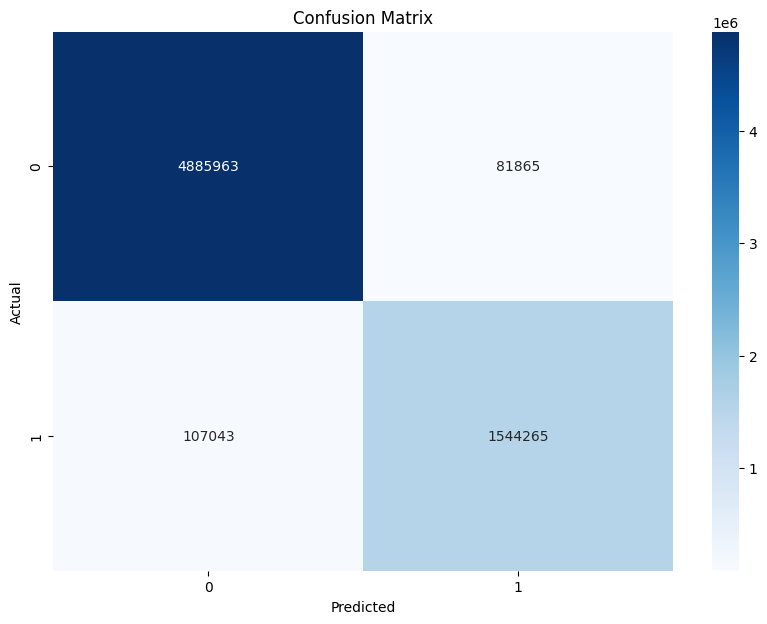

AUC: 0.9593


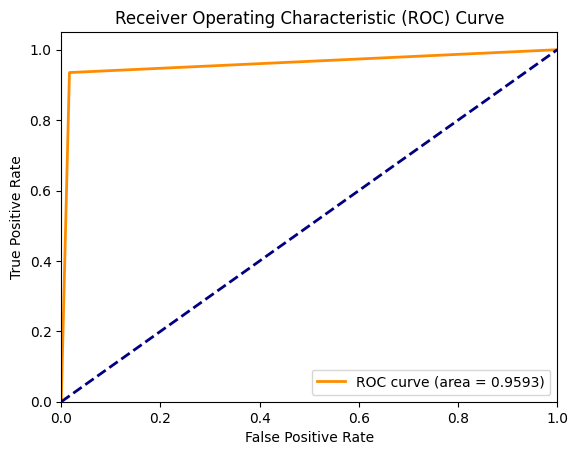

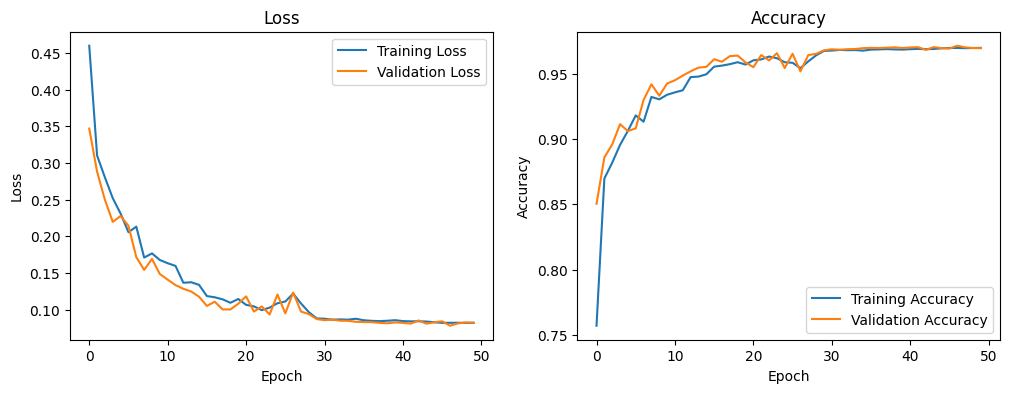

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, f1_score, accuracy_score, precision_score, recall_score, jaccard_score

def dice_coefficient(y_true, y_pred, smooth=1):
    intersection = np.sum(y_true * y_pred)
    return (2. * intersection + smooth) / (np.sum(y_true) + np.sum(y_pred) + smooth)

def pixel_accuracy(y_true, y_pred):
    return np.sum(y_true == y_pred) / y_true.size

# Check if the best model file exists
if os.path.exists('best_model.h5'):
    model.load_weights('best_model.h5')
else:
    print("Best model file not found. Ensure the training process saved the best model.")

# Evaluate on validation data
val_steps = len(df_val) // 4  # Adjust batch size to match the training
loss, accuracy = model.evaluate(val_dataset, steps=val_steps)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")

# Get validation data
def get_val_data(val_dataset, dataset_length):
    val_images = []
    val_masks = []
    for images, masks in val_dataset.unbatch().take(dataset_length):
        val_images.append(images.numpy())
        val_masks.append(masks.numpy())
    return np.array(val_images), np.array(val_masks)

val_images, val_masks = get_val_data(val_dataset, len(df_val))

# Predict on validation data
val_predictions = model.predict(val_images)

# Threshold predictions to get binary output
val_predictions_thresholded = (val_predictions > 0.5).astype(np.uint8)
val_masks_thresholded = (val_masks > 0.5).astype(np.uint8)

# Flatten the arrays for metric calculation
val_masks_flat = val_masks_thresholded.flatten()
val_predictions_flat = val_predictions_thresholded.flatten()

# Calculate Pixel Accuracy
pixel_acc = pixel_accuracy(val_masks_flat, val_predictions_flat)
print(f'Pixel Accuracy: {pixel_acc:.4f}')

# Calculate F1 Score
f1 = f1_score(val_masks_flat, val_predictions_flat)
print(f'F1 Score: {f1:.4f}')

# Calculate Accuracy
accuracy = accuracy_score(val_masks_flat, val_predictions_flat)
print(f'Accuracy: {accuracy:.4f}')

# Calculate Precision
precision = precision_score(val_masks_flat, val_predictions_flat)
print(f'Precision: {precision:.4f}')

# Calculate Recall
recall = recall_score(val_masks_flat, val_predictions_flat)
print(f'Recall: {recall:.4f}')

# Calculate Jaccard Index (IoU)
iou = jaccard_score(val_masks_flat, val_predictions_flat)
print(f'Jaccard Index (IoU): {iou:.4f}')

# Calculate Dice Coefficient
dice = dice_coefficient(val_masks_flat, val_predictions_flat)
print(f'Dice Coefficient: {dice:.4f}')

# Plot Confusion Matrix
def plot_confusion_matrix(val_masks, val_predictions):
    cm = confusion_matrix(val_masks, val_predictions)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

plot_confusion_matrix(val_masks_flat, val_predictions_flat)

# Plot ROC Curve and calculate AUC
fpr, tpr, _ = roc_curve(val_masks_flat, val_predictions_flat)
roc_auc = auc(fpr, tpr)
print(f'AUC: {roc_auc:.4f}')

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Plot training history
plt.figure(figsize=(12, 4))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


              precision    recall  f1-score   support

           0              0.9497    0.9707    0.9601        43
           1              0.9497    0.9352    0.9424        58
           accuracy                           0.9707       101
           macro avg      0.9497    0.9530    0.9512       101
           weighted avg   0.9497    0.9707    0.9595       101

1/1 [==============================] - 0s 205ms/step


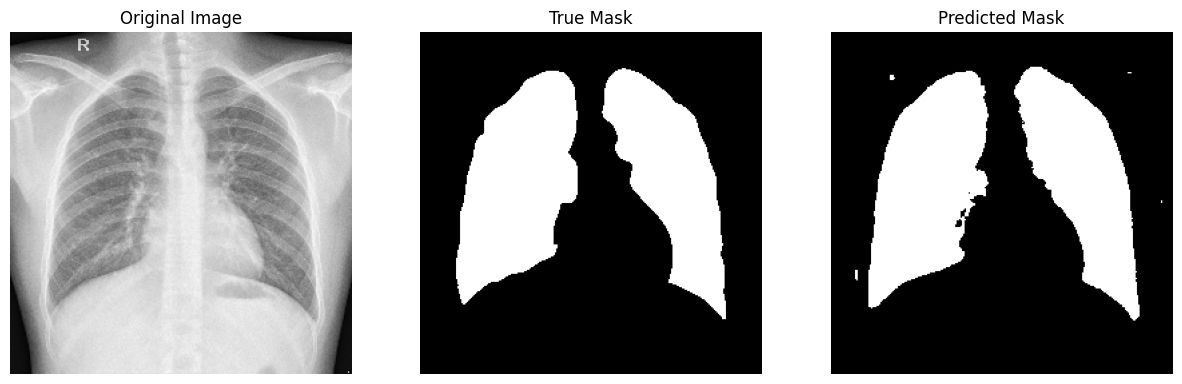

1/1 [==============================] - 0s 171ms/step


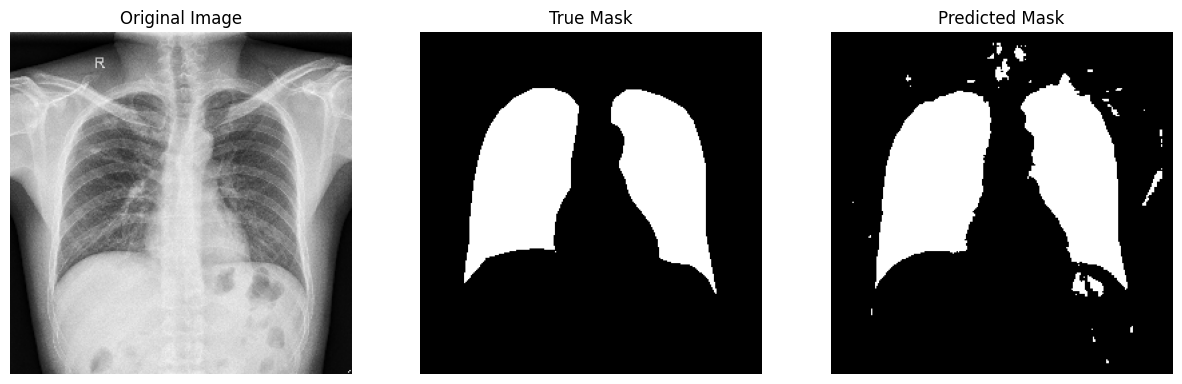

1/1 [==============================] - 0s 166ms/step


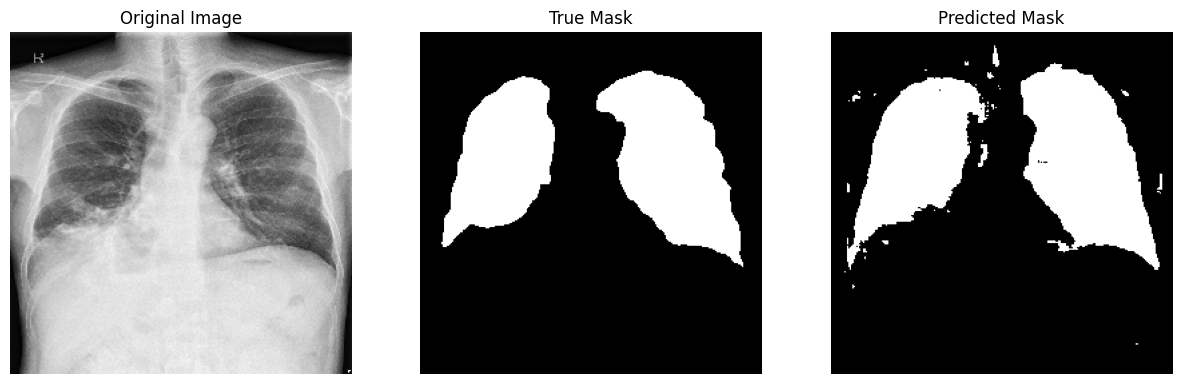

1/1 [==============================] - 0s 170ms/step


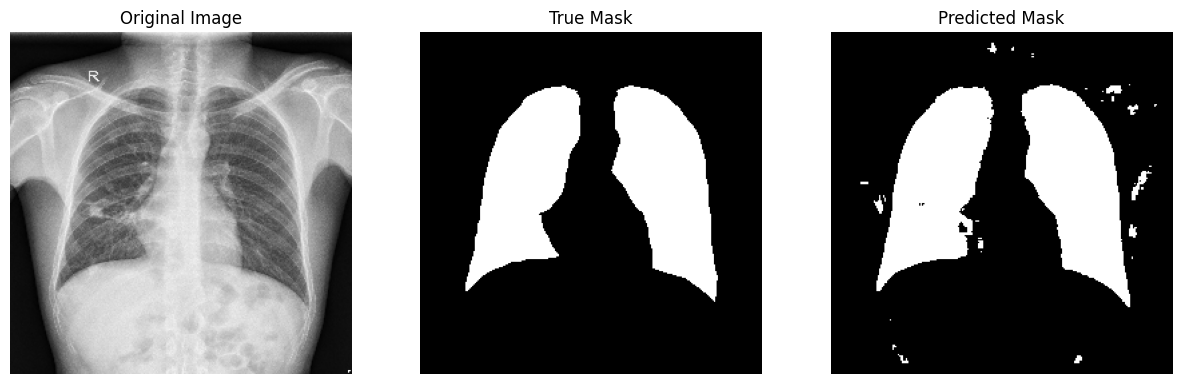

1/1 [==============================] - 0s 165ms/step


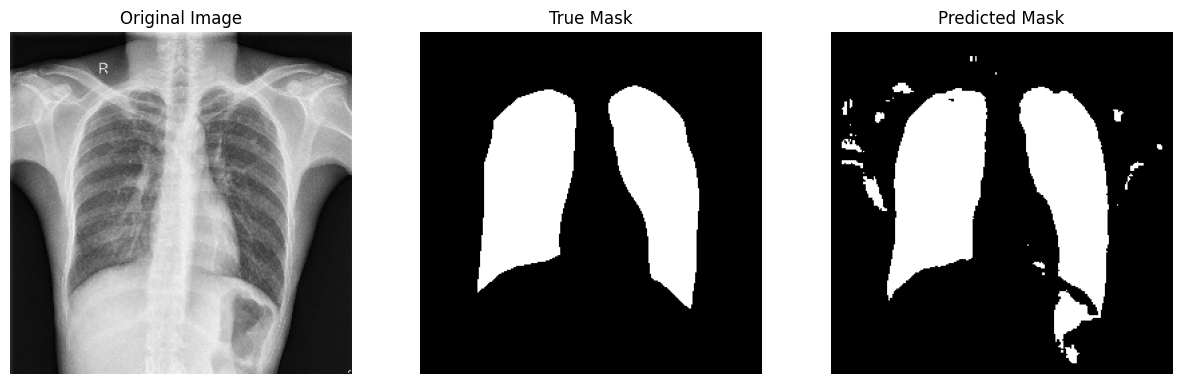

In [ ]:
def plot_sample_predictions(df, model, num_samples=3):
    for i in range(num_samples):
        img_path = df['Image'].iloc[i]
        mask_path = df['Mask'].iloc[i]

        img = load_img(img_path, target_size=(256, 256))
        img_array = img_to_array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)

        mask = load_img(mask_path, target_size=(256, 256), color_mode="grayscale")
        mask_array = img_to_array(mask) / 255.0

        pred_mask = model.predict(img_array)[0]
        pred_mask = (pred_mask > 0.5).astype(np.uint8)

        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        axes[0].imshow(img)
        axes[0].set_title('Original Image')
        axes[0].axis('off')

        axes[1].imshow(mask_array[:, :, 0], cmap='gray')
        axes[1].set_title('True Mask')
        axes[1].axis('off')

        axes[2].imshow(pred_mask[:, :, 0], cmap='gray')
        axes[2].set_title('Predicted Mask')
        axes[2].axis('off')

        plt.show()

# Plot sample predictions
plot_sample_predictions(df_val, model, num_samples=5)


In [ ]:
import os
import matplotlib.pyplot as plt

# Check if the best model file exists
if os.path.exists('best_model.h5'):
    model.load_weights('best_model.h5')
else:
    print("Best model file not found. Ensure the training process saved the best model.")

# Evaluate on validation data
val_steps = len(df_val) // 32

loss, accuracy = model.evaluate(val_generator, steps=val_steps)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")

# Plot training history
plt.figure(figsize=(12, 4))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


NameError: name 'df_val' is not defined

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, f1_score, accuracy_score, precision_score, recall_score
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model('best_model.h5')

# Function to unbatch and collect validation dataset
def get_val_data(val_dataset, dataset_length):
    val_images = []
    val_masks = []
    for images, masks in val_dataset.unbatch().take(dataset_length):
        val_images.append(images.numpy())
        val_masks.append(masks.numpy())
    return np.array(val_images), np.array(val_masks)

# Get the validation data
val_images, val_masks = get_val_data(val_dataset, len(df_val))

# Predict on validation data
val_predictions = model.predict(val_images)

# Threshold predictions to get binary output
val_predictions_thresholded = (val_predictions > 0.5).astype(np.uint8)
val_masks_thresholded = (val_masks > 0.5).astype(np.uint8)

# Flatten the arrays for metric calculation
val_masks_flat = val_masks_thresholded.flatten()
val_predictions_flat = val_predictions_thresholded.flatten()

# Calculate F1 Score
f1 = f1_score(val_masks_flat, val_predictions_flat)
print(f'F1 Score: {f1:.4f}')

# Calculate Efficiency (here we use accuracy as a proxy for efficiency)
accuracy = accuracy_score(val_masks_flat, val_predictions_flat)
print(f'Accuracy: {accuracy:.4f}')

# Calculate Precision
precision = precision_score(val_masks_flat, val_predictions_flat)
print(f'Precision: {precision:.4f}')

# Calculate Recall
recall = recall_score(val_masks_flat, val_predictions_flat)
print(f'Recall: {recall:.4f}')

# Plot Confusion Matrix
def plot_confusion_matrix(val_masks, val_predictions):
    cm = confusion_matrix(val_masks, val_predictions)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

plot_confusion_matrix(val_masks_flat, val_predictions_flat)

# Plot ROC Curve and calculate AUC
fpr, tpr, _ = roc_curve(val_masks_flat, val_predictions_flat)
roc_auc = auc(fpr, tpr)
print(f'AUC: {roc_auc:.4f}')

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Plot Model Accuracy and Loss over Epochs
def plot_accuracy_and_loss(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

plot_accuracy_and_loss(history)


NameError: name 'val_dataset' is not defined